# Prepare data for PCA-rearing-detection method

1. Already have a baseline methods to detect the rearing period
2. Get the rearing time from the baseline method as the training set
3. Train the PCA-rearing detection model


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from base import MultiDaysBeaconPosition, BeaconPosition
from scipy.stats import sem
from utils.basic_utils import get_tags
from utils.baseline_method import determine_rearing_period
from sklearn.decomposition import PCA

In [2]:
root_path = '../Data/Raw/'
rat_id = 'FS10'
rat_subdirectories = glob(root_path+rat_id+'/*/' )

tags = get_tags(rat_subdirectories)

# 1. Load data with different tags

In [3]:
tag_id = 0

In [4]:
this_tag = BeaconPosition(rat_subdirectories[tag_id], tags[tag_id], True, True)

In [188]:
unit_time = np.mean(this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
print(unit_time)

0.016694419627324594


# 2. Prepare data given T, tau

set T = 200 bins, tau = 10 bin

In [6]:
# set the parameters
save_fig = False # whether save the fig for the results

T = 200
tau = 10
group_step = 20

height_thresh = 0.6 # threshold for height/z to determine rearing

# get some important value for variable 
xy_speed = np.insert(this_tag.speed,0,0) # speed on xy planar insert 0 at the beginning of the speed array to make the size same
z_speed = np.divide(this_tag.position_data[1:,3] - this_tag.position_data[:-1,3], this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
z_speed = np.insert(z_speed,0,0) # insert 0 at the beginning of the speed array to make the size same 

z = this_tag.position_data[:,3]

In [7]:
z.shape

(108578,)

In [8]:
## inital goups
group_lists = []

for boundary in np.arange(0, T, group_step):
    print(boundary)
    group_lists.append([])

0
20
40
60
80
100
120
140
160
180


In [9]:
group_lists

[[], [], [], [], [], [], [], [], [], []]

In [162]:
def generate_tau_sample(features, tau = 10, step = 2):
    '''
    generate a list of tau length sample by slicing the window along the whole time series
    features: [n,k]
    
    return : array in[k,m]
    '''
    # determine the size of the final output
    
    T = features.shape[0]
    k = features.shape[1] # # of features interested in 
    tau_samples = []# np.zeros((tau + (T-tau)//step, k))
    
    for end_idx in np.arange(tau, T+1, step):
        tau_samples.append(features[end_idx-tau: end_idx,:])
    
    
    return np.vstack(np.array(tau_samples)).T

In [11]:
n = T
N = n*20

for Begin in np.arange(0, z.shape[0],N):
    fig, axis = plt.subplots(4,5, figsize = (19,16), sharey = True, sharex = True)
    axis = axis.flatten()

    fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                        hspace=0.2, wspace=0.3)


    begin_idxs = np.arange(Begin,Begin+N, n)

    for i,begin_idx in enumerate(begin_idxs):
        this_features = np.zeros((n,3))
        this_features[:,0] = z[begin_idx: begin_idx+n]
        this_features[:,1] = z_speed[begin_idx: begin_idx+n]
        this_features[:,2] = xy_speed[begin_idx: begin_idx+n]
        this_rearing = determine_rearing_period(this_features,height_thresh= height_thresh, zspeed_thresh=0.5, xspeed_drop_thresh=0.2, gap_tolerance= 5, total_tolerance=10, )
        
        ## put this rearing results to the right group
        group_idx = int(len(this_rearing)/group_step)

        # plot results
    #     axis[i].plot(z[begin_idx: begin_idx+n],label ='height')
    #     if len(this_rearing)>0:
    #         x_bool = np.zeros(n) ==1
    #         x_bool[this_rearing] = True
    #         axis[i].fill_between(np.arange(0,n), 0.45, 0.80, alpha = 0.4, label = 'rearing period', where = x_bool, interpolate = True, step = 'mid')
    #     axis[i].set_xlabel('time bins', fontsize = 14)
    #     axis[i].set_ylabel('height', fontsize = 14)
    #     # break
        
    #     axis[i].legend(loc =1)
    #     #print(i)
        
    # title = 'Rearing period detection of rat %s, height thresh = %.2f, bins = [%d: %d]'%(rat_id, height_thresh, Begin, Begin+N)
    # fig.suptitle(title, fontsize = 16)
    # if save_fig:
    #     fig.savefig('results/easy_method/%s/%s.png'%(rat_id, title), format ='png',)
        

In [12]:
def organize_group_list(group_lists):
    '''
    organize the group list to be used in PCA
    '''
    group_len = []
    for this_list in group_lists:
        group_len.append(len(this_list))
    min_len = np.min(group_len)
    
    # randomly choose min(group_len) samples 
    features_matrix = []
    for i,this_list in enumerate(group_lists):
        random_idx = np.random.choice(np.arange(0,group_len[i]),size = min_len, replace= False) # no replace
        random_sample = np.asarray(this_list)[random_idx]
        array_sample = np.hstack(np.hstack(random_sample)) # feature1 feature2 feature3
        features_matrix.append(array_sample)
    
    return np.asarray(features_matrix)
        

In [166]:
n = T
# get the initial group list
group_lists = []
for boundary in np.arange(0, T+1, group_step):
    group_lists.append([])
    
begin_idx = 0
while begin_idx+n <= z.shape[0]:
   
    this_features = np.zeros((n,3))
    this_features[:,0] = z[begin_idx: begin_idx+n]
    this_features[:,1] = z_speed[begin_idx: begin_idx+n]
    this_features[:,2] = xy_speed[begin_idx: begin_idx+n]
    this_rearing = determine_rearing_period(this_features,height_thresh= height_thresh, zspeed_thresh=0.5, xspeed_drop_thresh=0.2, gap_tolerance= 5, total_tolerance=10, )
    
    ## put this rearing results to the right group
    group_idx = int(len(this_rearing)/group_step)
    
    ## get the pca features
    pca_features = np.zeros((n,3))
    pca_features[:,0] = z[begin_idx: begin_idx+n]
    pca_features[:,1] = this_tag.position_data[begin_idx: begin_idx+n, 6]
    pca_features[:,2] = z_speed[begin_idx: begin_idx+n]
    
    tau_samples = generate_tau_sample(pca_features,tau= tau, step = 10)
    
    group_lists[group_idx].append(tau_samples)
    
    begin_idx+= n

# combine the last two
group_lists[-2].extend(group_lists[-1])
group_lists = group_lists[:-1]

In [14]:
for this_list in group_lists:
    print(len(this_list))

314
16
32
30
46
25
23
13
16
27


In [168]:
pca_features.shape

(200, 3)

# 3.1 Try PCA method, faltten everything horizontally

In [169]:
x = organize_group_list(group_lists)

In [255]:
x.shape

(10, 7800)

In [170]:
# normalized x
norm_x = x - np.mean(x, axis = 0)

In [171]:
pca = PCA(n_components=10)
pca.fit(norm_x)

PCA(n_components=10)

In [172]:
ratio = pca.explained_variance_ratio_

In [173]:
ratio

array([4.07044328e-01, 1.34867793e-01, 9.90941234e-02, 7.95830037e-02,
       7.80704057e-02, 6.52525057e-02, 5.76823820e-02, 4.58314055e-02,
       3.25740524e-02, 7.92874777e-31])

Text(0, 0.5, 'explained variance')

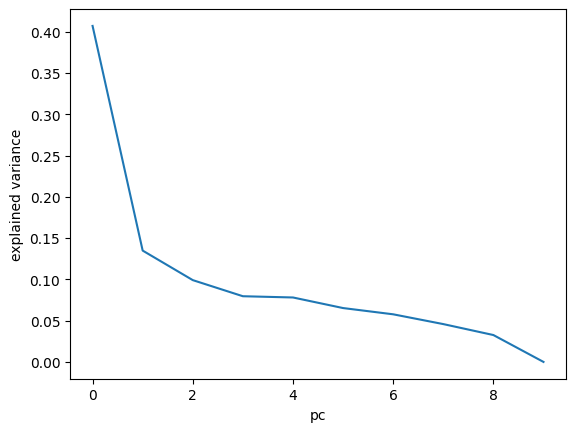

In [174]:
plt.plot(ratio)
plt.xlabel('pc')
plt.ylabel('explained variance')

In [175]:
eigen_vec = pca.components_
first_pc = np.asarray(np.hsplit(eigen_vec[0], 3))  # array in [3, n*t* sample ] 

In [250]:
print(first_pc.shape)

(3, 2600)


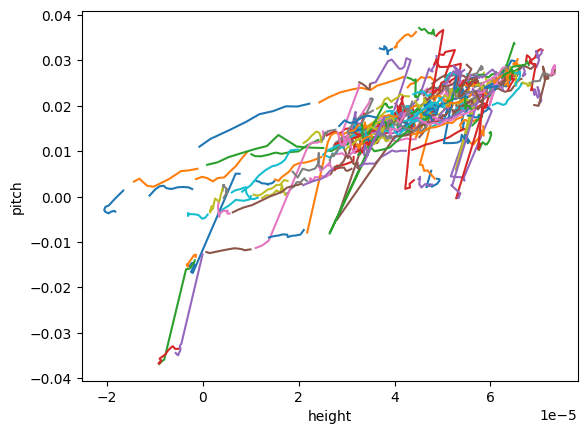

In [251]:
idx = 0
i = 0
while (idx + tau <= first_pc.shape[1]):

    plt.plot(first_pc[0, idx:idx + tau], first_pc[1,idx:idx + tau])
    plt.xlabel('height')
    plt.ylabel('pitch')
    i += 1
    idx += tau

In [177]:
first_pc.shape

(3, 2600)

# 3.1 Average across different T

In [178]:
def organize_group_average(group_lists):
    '''
    organize the group list to be used in PCA
    '''
    
    features_matrix = []
    for i,this_list in enumerate(group_lists):
       
        array_sample = np.asarray(this_list) # feature1 feature2 feature3
        ave_sample = np.mean(array_sample, axis=0)
        features_matrix.append(np.hstack(ave_sample))
    
    return np.asarray(features_matrix)
        

In [179]:
x_ave = organize_group_average(group_lists)
norm_xave = x_ave - x_ave.mean(axis=0)

In [180]:
pca_ave = PCA(n_components=10)
pca_ave.fit(norm_xave)

PCA(n_components=10)

[8.66606715e-01 5.81203074e-02 2.95540316e-02 2.71782494e-02
 8.16513120e-03 5.45480731e-03 3.19888419e-03 1.25138018e-03
 4.70493876e-04 2.06528909e-32]


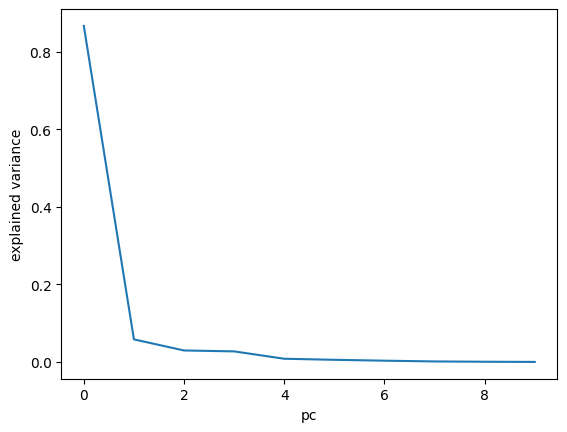

In [181]:
plt.plot(pca_ave.explained_variance_ratio_)
plt.xlabel('pc')
plt.ylabel('explained variance')
print(pca_ave.explained_variance_ratio_)

## plot first pc

In [183]:
eigen_vec_ave = pca_ave.components_
first_pcave = np.asarray(np.hsplit(eigen_vec_ave[0], 3))  # array in [3, n*t* sample ] 

In [184]:
first_pcave.shape

(3, 200)

In [145]:
eigen_vec_ave

10

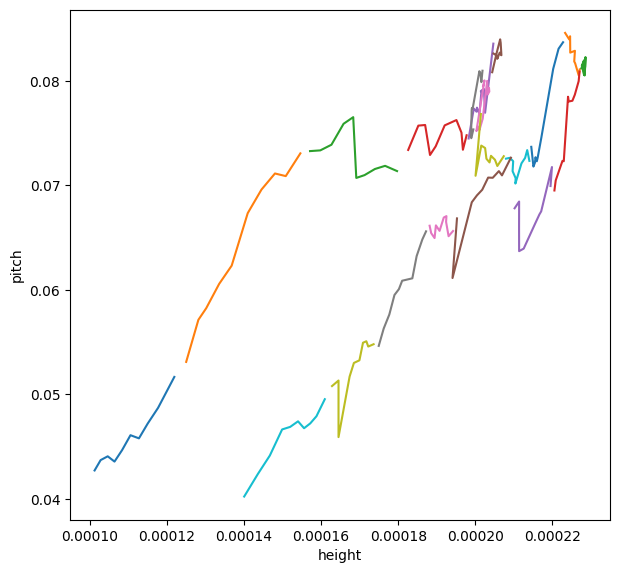

In [223]:
idx = 0
i = 0
fig, axis = plt.subplots(1,1, figsize = (6,6), sharey = True,sharex = True)
# axis = axis.flatten()

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
while (idx + tau <= first_pcave.shape[1]) :

    axis.plot(first_pcave[0, idx:idx + tau], first_pcave[1,idx:idx + tau])
    axis.set_xlabel('height')
    axis.set_ylabel('pitch')
    i += 1
    idx += tau

In [ ]:
plt.scatter(x_ave[0,0:],)

In [44]:
a = np.asarray(group_lists[0])
print(a.shape)
b = np.mean(a, axis = 0)
print(b.shape)
c = np.hstack(b)
print(c.shape)

(314, 3, 960)
(3, 960)
(2880,)


# 3.2 second understanding of the methods

For each condition, do PCA seperately

In [229]:
def organize_group_list_sperately(group_lists):
    '''
    organize the group list to be used in PCA
    '''
    
    # randomly choose min(group_len) samples 
    features_list = []
    for i,this_list in enumerate(group_lists):
        array_sample = np.asarray(this_list) 
        this_features= np.vstack(np.transpose(array_sample,(1,2,0))).T
        features_list.append(this_features)
        
    return features_list
        

In [227]:
a = np.asarray(group_lists[0])
print(a.shape)
b = np.transpose(a,(1,2,0))
print(b.shape)
c = np.vstack(b)
print(c.shape)

(314, 3, 200)
(3, 200, 314)
(600, 314)


In [228]:
c[0:200,0] == a[0,0,:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [230]:
x3 = organize_group_list_sperately(group_lists)

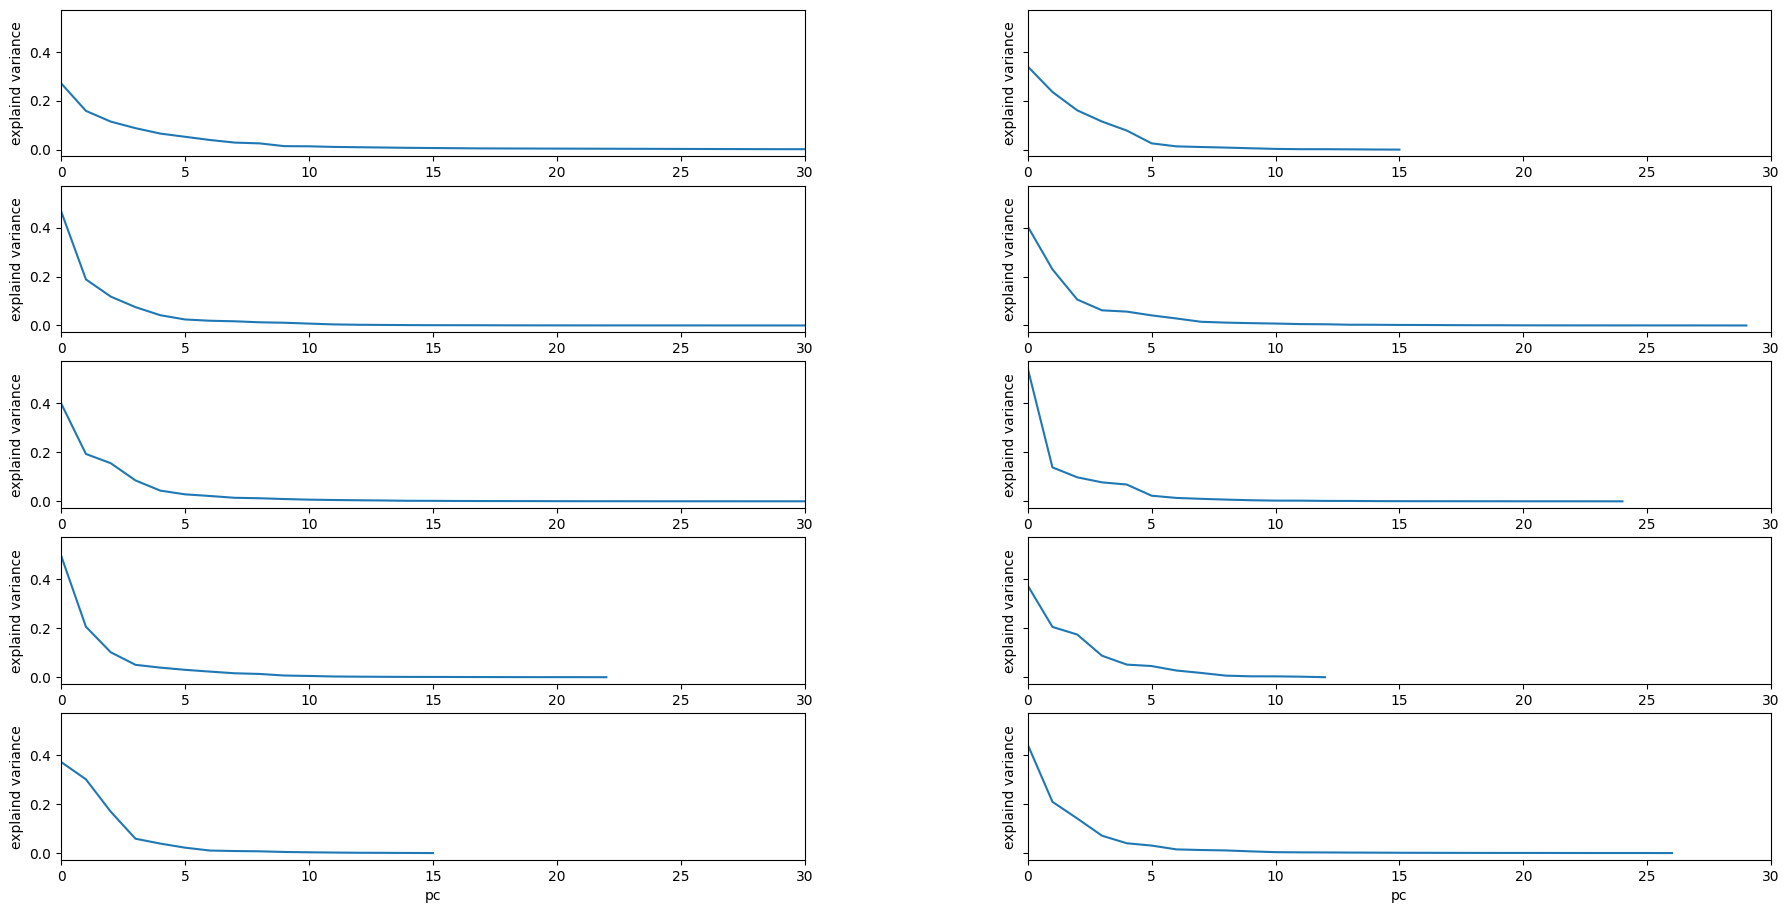

In [253]:
fig, axis = plt.subplots(5,2, figsize = (19,10), sharey = True)
axis = axis.flatten()

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
pca_models =[]
for i, xi in enumerate(x3):
    this_pca = PCA(n_components=xi.shape[0])
    norm_xi = xi - xi.mean(axis = 0)
    this_pca.fit(xi)
    pca_models.append(this_pca)
    axis[i].plot(this_pca.explained_variance_ratio_)
    axis[i].set_xlabel('pc')
    axis[i].set_ylabel('explaind variance')
    axis[i].set_xlim(0,30)

In [232]:
pca0 = pca_models[0]

In [233]:
eigen_vec_pca0 = pca0.components_
first_pca0 = np.asarray(np.hsplit(eigen_vec_pca0[0],3))
print(first_pca0.shape)

(3, 200)


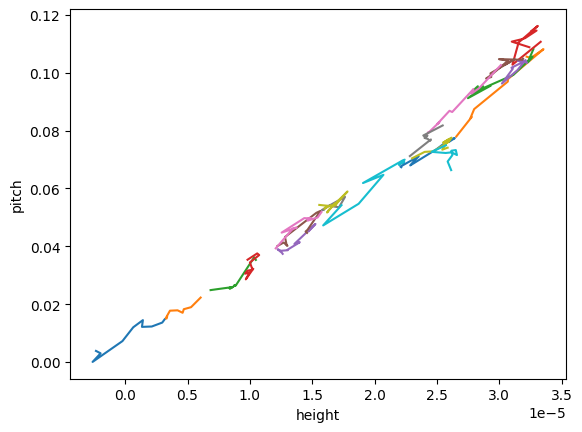

In [234]:
idx = 0
i = 0
while (idx + tau <= first_pca0.shape[1]):

    plt.plot(first_pca0[0, idx:idx + tau], first_pca0[1,idx:idx + tau])
    plt.xlabel('height')
    plt.ylabel('pitch')
    i += 1
    idx += tau

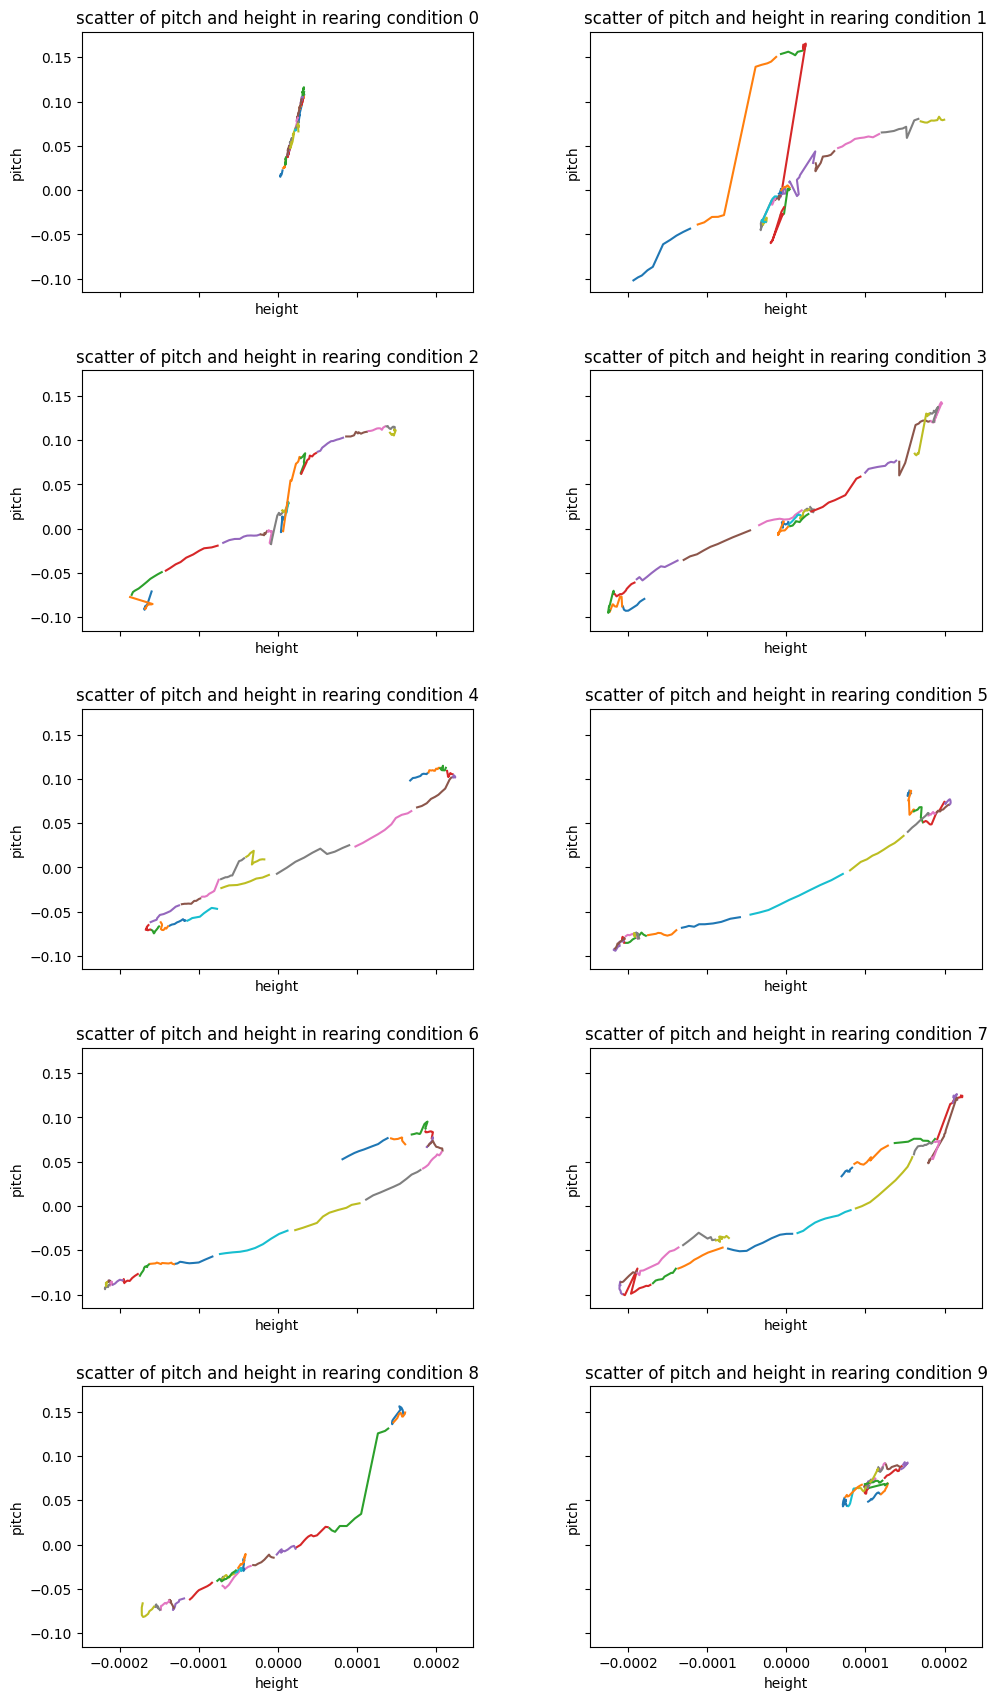

In [254]:
fig, axis = plt.subplots(5,2, figsize = (10,19), sharey = True,sharex = True)
axis = axis.flatten()

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.3, wspace=0.3)
for i, xi in enumerate(x3):
    this_pca = pca_models[i]
    
    this_eigen_vec = this_pca.components_
    this_first_pc = np.asarray(np.hsplit(this_eigen_vec[0],3))
    
    
    idx = 0
    while (idx + tau <= this_first_pc.shape[1]):
    
        idx += tau
        axis[i].plot(this_first_pc[0, idx:idx + tau], this_first_pc[1,idx:idx + tau])
        axis[i].set_xlabel('height')
        axis[i].set_ylabel('pitch')
        axis[i].set_title('scatter of pitch and height in rearing condition %d'%i)


## 3.3 more seperately, 

In [239]:
def organize_group_list_sperate_T(sperately_group_list, k = 3,tau = 10):
    '''
    organize the group list to be used in PCA
    '''
    
    # randomly choose min(group_len) samples 
    features_list = []
    for i,this_list in enumerate(sperately_group_list):
        array_sample = np.asarray(this_list) # (314, 20, 3, 10)
        temp = np.vstack(array_sample)
        this_features= np.zeros((temp.shape[0],tau*k))
        this_features[:,0:tau] = temp[:,0,:]
        this_features[:,tau:2*tau] = temp[:,1,:]
        this_features[:,2*tau:3*tau] = temp[:,2,:]
        features_list.append(this_features)
        
    return features_list
        

In [246]:
a =np.asarray (sperately_group_list[0])
print(a.shape)
b = np.vstack(a)
print(b.shape)

(314, 20, 3, 10)
(6280, 3, 10)


In [242]:
n = T
# get the initial group list
sperately_group_list = []
for boundary in np.arange(0, T+1, group_step):
    sperately_group_list.append([])
    
begin_idx = 0
while begin_idx+n <= z.shape[0]:
   
    this_features = np.zeros((n,3))
    this_features[:,0] = z[begin_idx: begin_idx+n]
    this_features[:,1] = z_speed[begin_idx: begin_idx+n]
    this_features[:,2] = xy_speed[begin_idx: begin_idx+n]
    this_rearing = determine_rearing_period(this_features,height_thresh= height_thresh, zspeed_thresh=0.5, xspeed_drop_thresh=0.2, gap_tolerance= 5, total_tolerance=10, )
    
    ## put this rearing results to the right group
    group_idx = int(len(this_rearing)/group_step)
    
    ## get the pca features
    
    pca_features = np.zeros((n,3))
    pca_features[:,0] = z[begin_idx: begin_idx+n]
    pca_features[:,1] = this_tag.position_data[begin_idx: begin_idx+n, 6]
    pca_features[:,2] = z_speed[begin_idx: begin_idx+n]
    
    tau_samples = generate_tau_sample(pca_features,tau = tau, step = 10)
    
    sperately_group_list[group_idx].append(np.asarray(np.hsplit(tau_samples,tau_samples.shape[-1]//tau)))
    
    begin_idx+= n

# combine the last two
sperately_group_list[-2].extend(sperately_group_list[-1])
sperately_group_list = sperately_group_list[:-1]

In [247]:
x4 = organize_group_list_sperate_T(sperately_group_list)

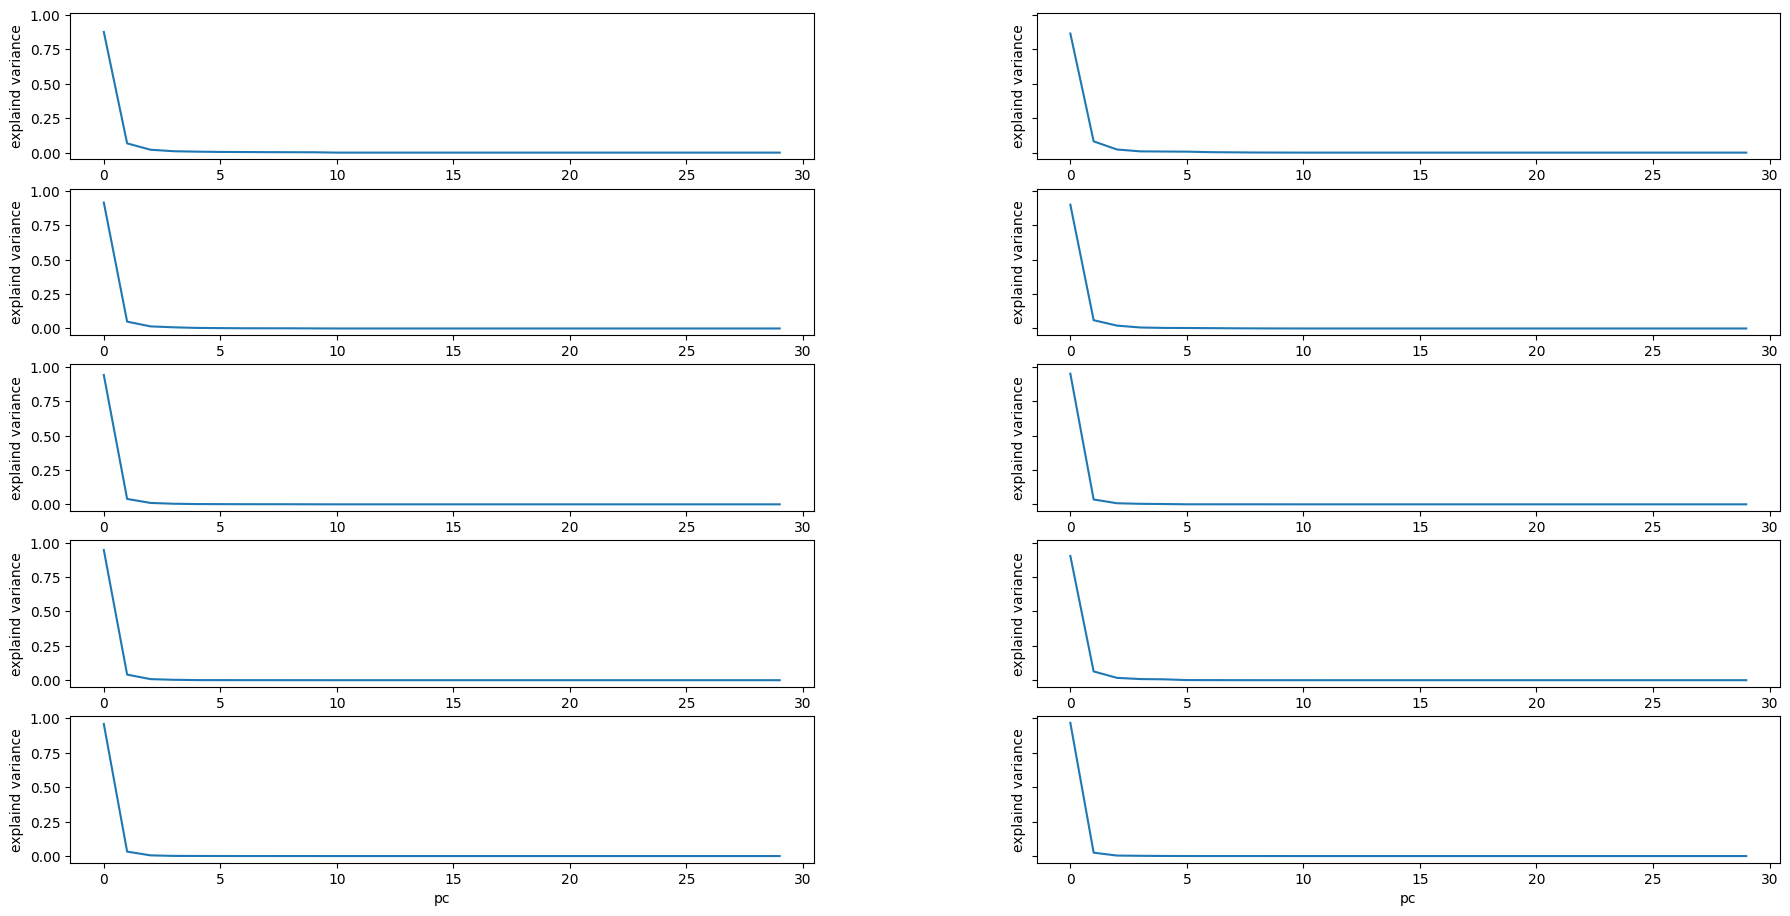

In [248]:
fig, axis = plt.subplots(5,2, figsize = (19,10), sharey = True)
axis = axis.flatten()

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
pca_models =[]
for i, xi in enumerate(x4):
    this_pca = PCA()
    norm_xi = xi - xi.mean(axis = 0)
    this_pca.fit(xi)
    pca_models.append(this_pca)
    axis[i].plot(this_pca.explained_variance_ratio_)
    axis[i].set_xlabel('pc')
    axis[i].set_ylabel('explaind variance')

In [109]:
a = np.asarray(sperately_group_list[0])
print(a.shape)
b = np.vstack(a)
print(b.shape)
c = np.hstack(b)
print(c.shape)

(314, 96, 3, 10)
(30144, 3, 10)
(3, 301440)


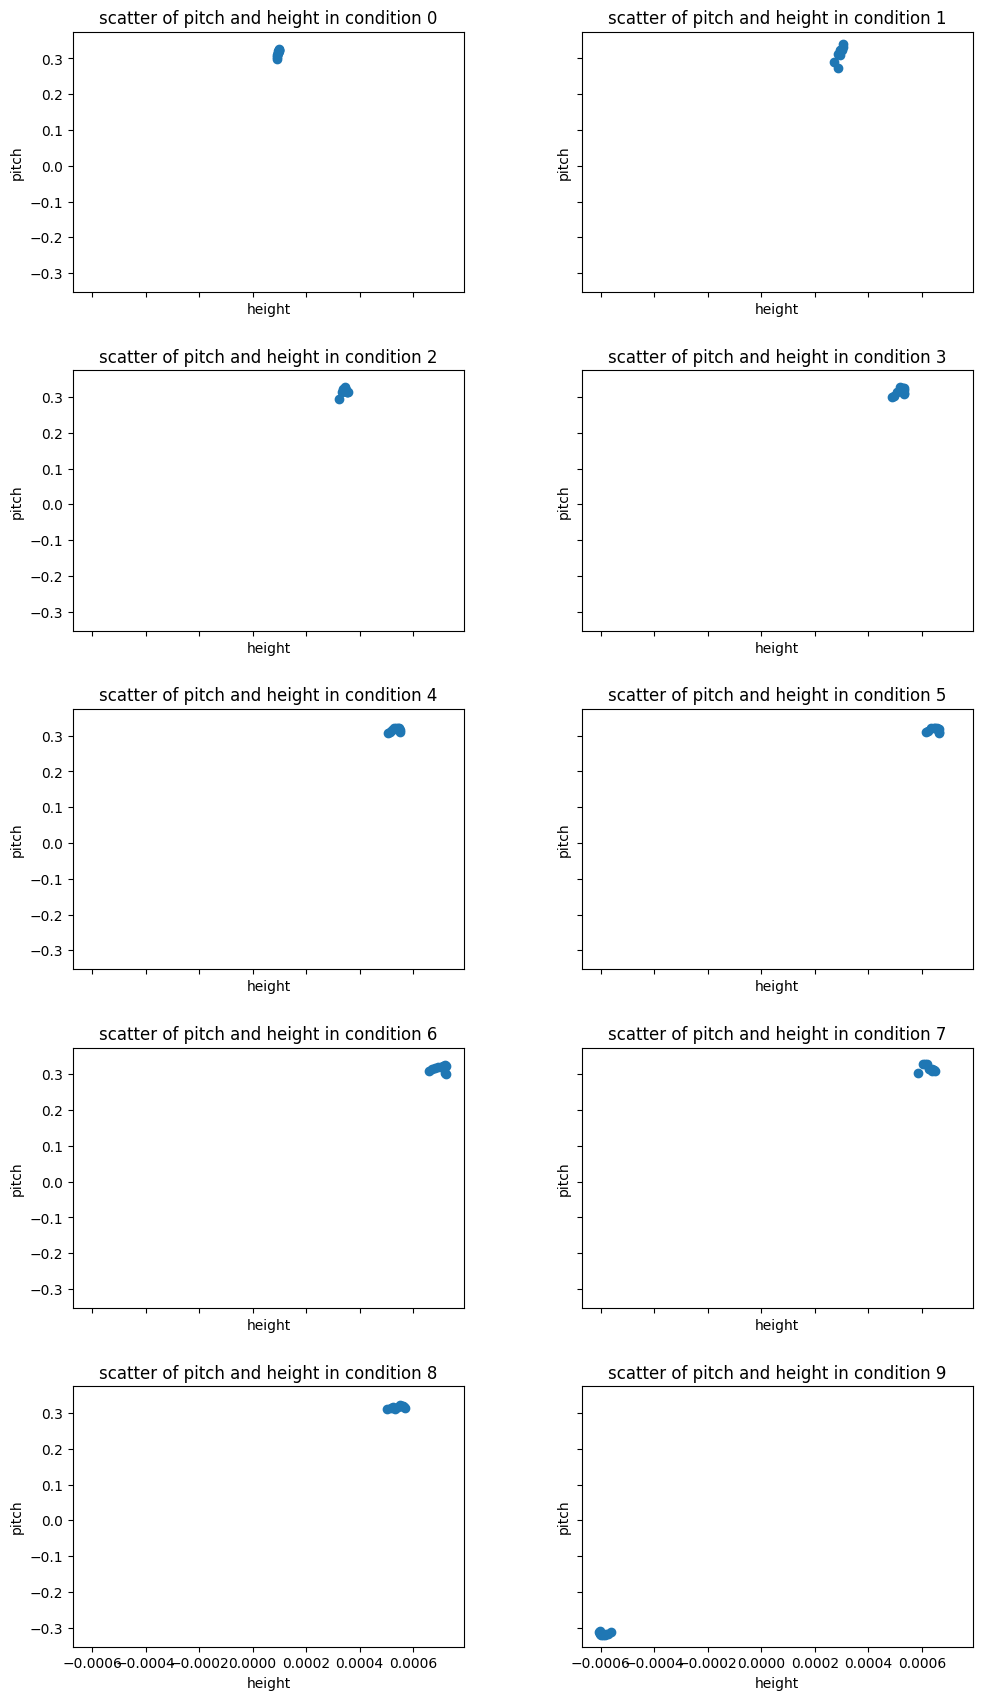

In [249]:
fig, axis = plt.subplots(5,2, figsize = (10,19), sharey = True,sharex= True)
axis = axis.flatten()

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.3, wspace=0.3)
for i, xi in enumerate(x3):
    this_pca = pca_models[i]
    
    this_eigen_vec = this_pca.components_
    this_first_pc = np.asarray(this_eigen_vec[0])
    
    
  
    
    axis[i].scatter(this_first_pc[0:tau], this_first_pc[tau: 2*tau])
    axis[i].set_xlabel('height')
    axis[i].set_ylabel('pitch')
    axis[i].set_title('scatter of pitch and height in condition %d'%i)